<a href="https://colab.research.google.com/github/mkh2097/CI_Image_Classification/blob/main/CI_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add , Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import get_file

import pathlib
import matplotlib.pyplot as plt


In [ ]:
data_directory = '/root/.keras/datasets/Images'
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
data_directory = get_file('Images', origin=dataset_url, untar = True)
data_directory = pathlib.Path(data_directory)
print(data_directory)

/root/.keras/datasets/Images


In [ ]:
img_height = 192
img_width = 192
batch_size = 32

# img_height = 224
# img_width = 224
# batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="training",
  shuffle = True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="validation",
  shuffle = False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


cls_number = len(train_ds.class_names)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:
def first_model():
  
  model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(cls_number)
  ])
  return model

In [ ]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
def resnet50():

  input_im = Input(shape=(img_height, img_width, 3)) # cifar 10 images size

  x = layers.experimental.preprocessing.Rescaling(1./255)(input_im)
  x = ZeroPadding2D(padding=(3, 3))(x)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(120, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [ ]:
def second_model():
  
  model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  # layers.experimental.preprocessing.RandomRotation(0.2),
  # layers.experimental.preprocessing.RandomZoom(.5, .2),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(cls_number)
  ])
  return model

In [ ]:
def mobile_net():
  input_im = (img_height, img_width, 3) # cifar 10 images size
  
  base_model = tf.keras.applications.MobileNetV2(input_shape= input_im, include_top=False, weights='imagenet')
  base_model.trainable = False

  model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_im),
    # layers.experimental.preprocessing.RandomFlip('horizontal'),
    # layers.experimental.preprocessing.RandomRotation(0.1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(120, activation='softmax')
  ])

  return model

In [ ]:
def xception():
  input_im = (img_height, img_width, 3) # cifar 10 images size
  
  base_model = tf.keras.applications.Xception(input_shape= input_im, include_top=False, weights='imagenet')
  base_model.trainable = False

  model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_im),
    # layers.experimental.preprocessing.RandomFlip('horizontal'),
    # layers.experimental.preprocessing.RandomRotation(0.1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(120, activation='softmax')
  ])

  return model

In [ ]:
def vgg():
  input_im = (img_height, img_width, 3) # cifar 10 images size
  
  base_model = tf.keras.applications.VGG19(input_shape= input_im, include_top=False, weights='imagenet')
  base_model.trainable = False

  model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_im),
    # layers.experimental.preprocessing.RandomFlip('horizontal'),
    # layers.experimental.preprocessing.RandomRotation(0.1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(120, activation='softmax')
  ])

  return model

In [ ]:
def alexnet():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(cls_number, activation='softmax')
    ])
    return model

In [ ]:
def result(model, epoche):
  #Report 
  model.summary()
  model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
  
  # tf.keras.optimizers.Adam(
  #     learning_rate=10, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
  #     name='Adam'
  # )

  #Train
  epochs=epoche
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  # Graph
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 192, 192, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0

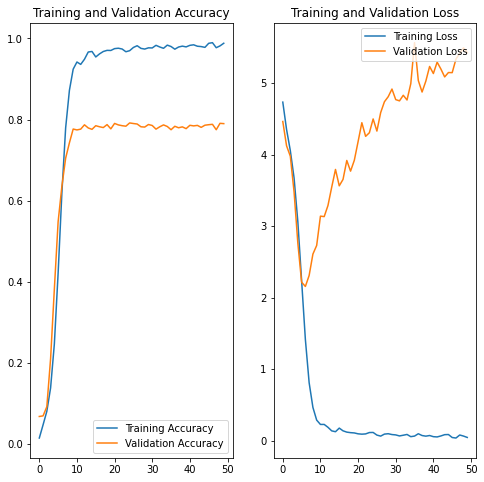

In [ ]:
#Usbaility = High
model = first_model()
result(model, 50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 192, 192, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 192, 192, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 192, 192, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 64)       

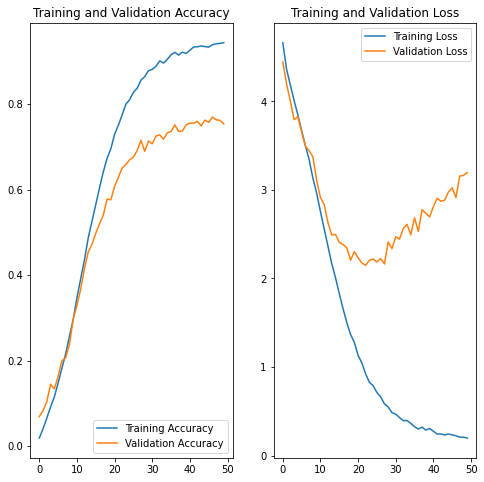

In [ ]:
#Usbaility = High
model = second_model()
result(model, 50)
# model.save_weights("weights.h5")

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 192, 192, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 198, 198, 3)  0           rescaling_2[0][0]                
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 96, 64)   9472        zero_padding2d[0][0]             
___________________________________________________________________________________________

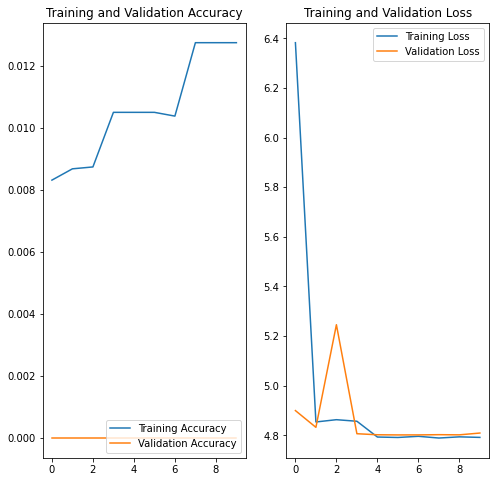

In [ ]:
#Usbaility = Low
model = resnet50()

#Transfer Learning
WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
# WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
#                        'releases/download/v0.2/'
#                        'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

weight_directory = get_file(fname='Weights', origin=WEIGHTS_PATH)
model.load_weights(weight_directory, by_name=True)
result(model, 10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 46, 46, 96)        34944     
_________________________________________________________________
batch_normalization_53 (Batc (None, 46, 46, 96)        384       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 96)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
batch_normalization_54 (Batc (None, 23, 23, 256)       1024      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 11, 11, 384)      

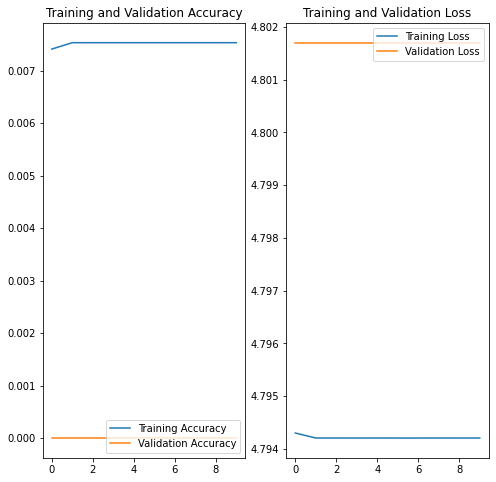

In [ ]:
#Usbaility = Very Low
model = alexnet()
result(model, 10)

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 192, 192, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
515/515 [==============================] - 20s 38ms/step - loss: 4.3224 - accuracy: 0.5338 - val_loss: 4.0892 - val_accuracy: 0.7493
Epoch 2/10
515/515 [=========

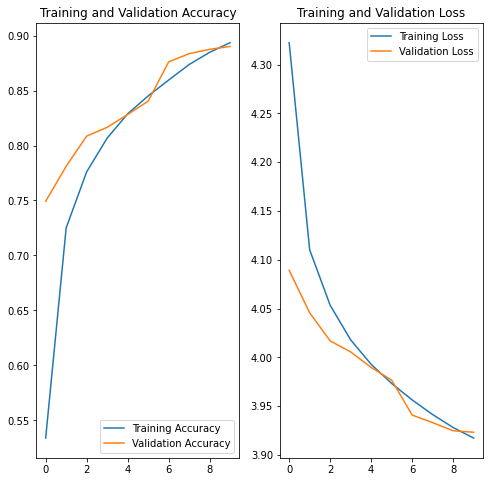

In [ ]:
model = mobile_net()
result(model, 10)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 192, 192, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               245880    
Total params: 21,107,360
Trainable params: 245,880
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/10
515/515 [==============================] - 63s 122ms/step - loss: 4.2303 - accuracy: 0.6072 - val_loss: 4.1285 - val_accuracy: 0.6905
Epoch 2/10
515/515 [==============================] - 61s 119ms/step - loss: 4.0837 - acc

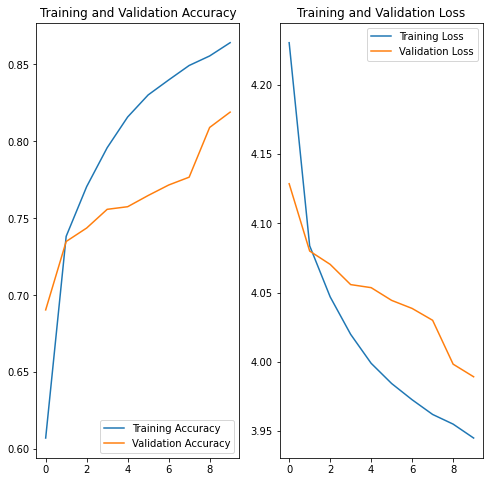

In [ ]:
model = xception()
result(model, 10)

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 192, 192, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               61560     
Total params: 20,085,944
Trainable params: 61,560
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/10
515/515 [==============================] - 72s 140ms/step - loss: 4.7823 - accuracy: 0.0190 - val_loss: 4.7507 - val_accuracy: 0.0836
Epoch 2/10
515/515 [=====

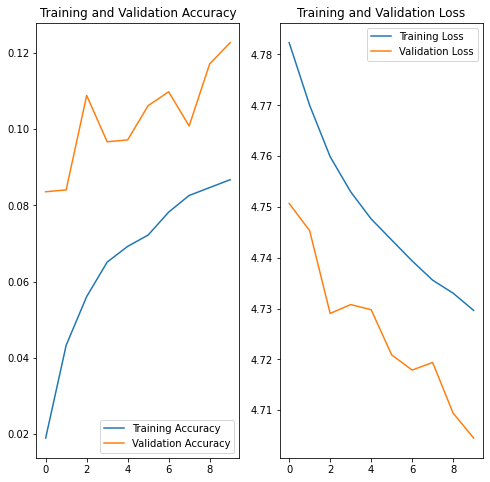

In [ ]:
model = vgg()
result(model, 10)

In [ ]:
# aug = ImageDataGenerator(
# 	# rotation_range=20,
# 	# zoom_range=0.15,
# 	# width_shift_range=0.2,
# 	# height_shift_range=0.2,
# 	shear_range=0.15,
# 	# horizontal_flip=True,
#   # validation_split=0.2,
# 	# fill_mode="nearest")
# )
# train_generator = aug.flow_from_directory(data_directory,
#   subset="training",
#   shuffle = True,
#   seed=123,
#   target_size=(img_height, img_width),
#   batch_size=64)

# print(train_generator.image_shape)
# print(train_generator)

# validation_generator = aug.flow_from_directory(data_directory,
#   subset="validation",
#   shuffle = False,
#   seed=123,
#   target_size=(img_height, img_width),
#   batch_size=batch_size)

# print(validation_generator.image_shape)
# print(validation_generator)
 
# # model.compile(optimizer='adam',
# #             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# #             metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# e = 10
# model.fit(
#     train_generator,
#     # steps_per_epoch = train_generator.samples // batch_size,
#     validation_data = validation_generator, 
#     # validation_steps = validation_generator.samples // batch_size,
#     epochs = 10)